Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_01.fits
Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_02.fits
Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_03.fits
Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_04.fits
Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_05.fits
Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_06.fits
Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_07.fits
Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_08.fits
Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_09.fits
Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_10.fits
Saved: C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\_aligned_11.fits
Saved: C:\

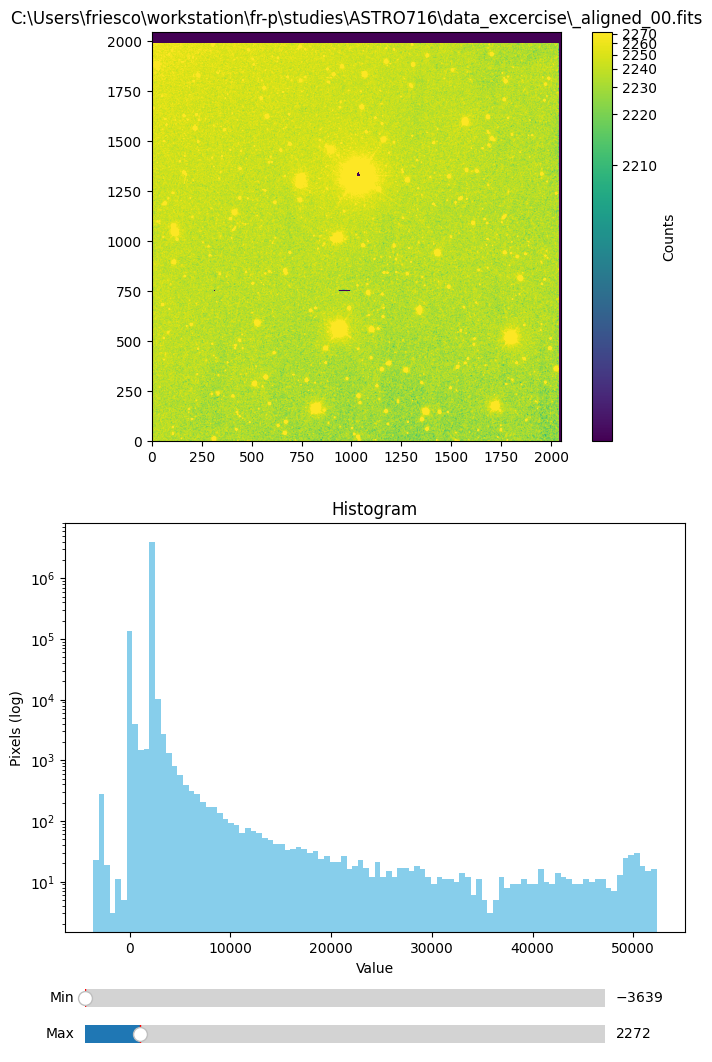

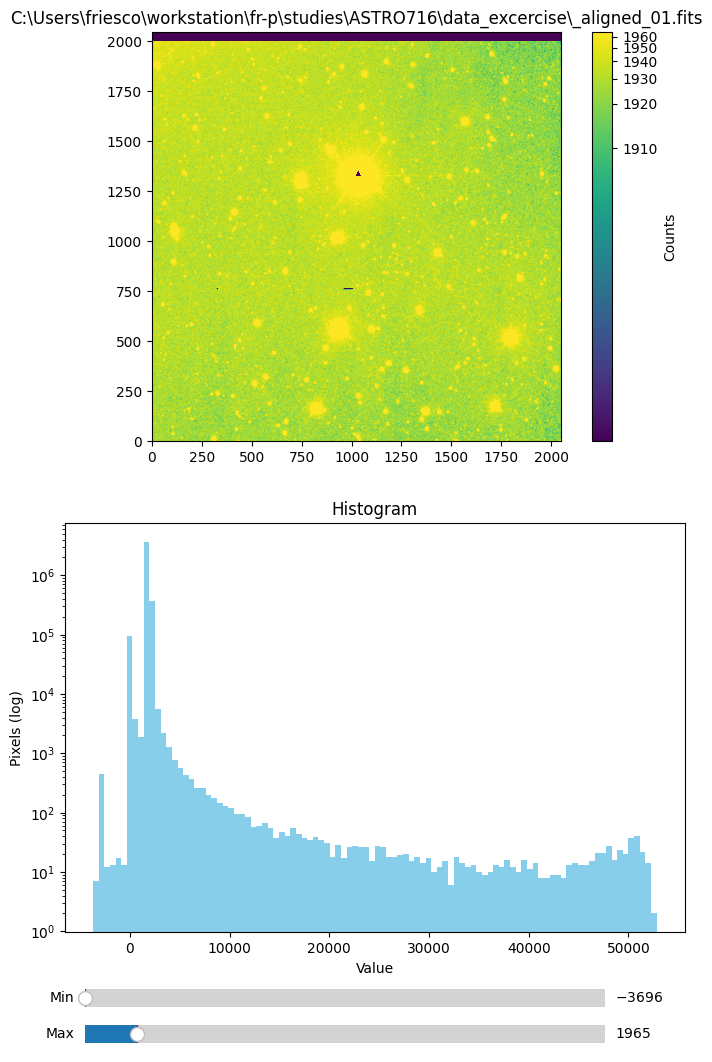

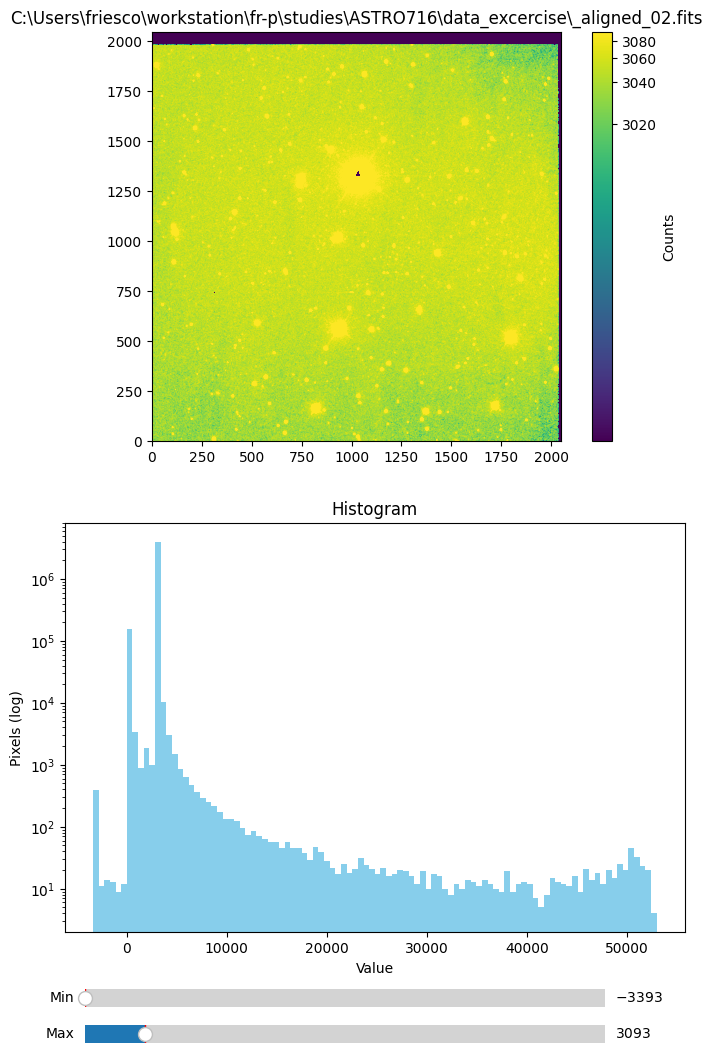

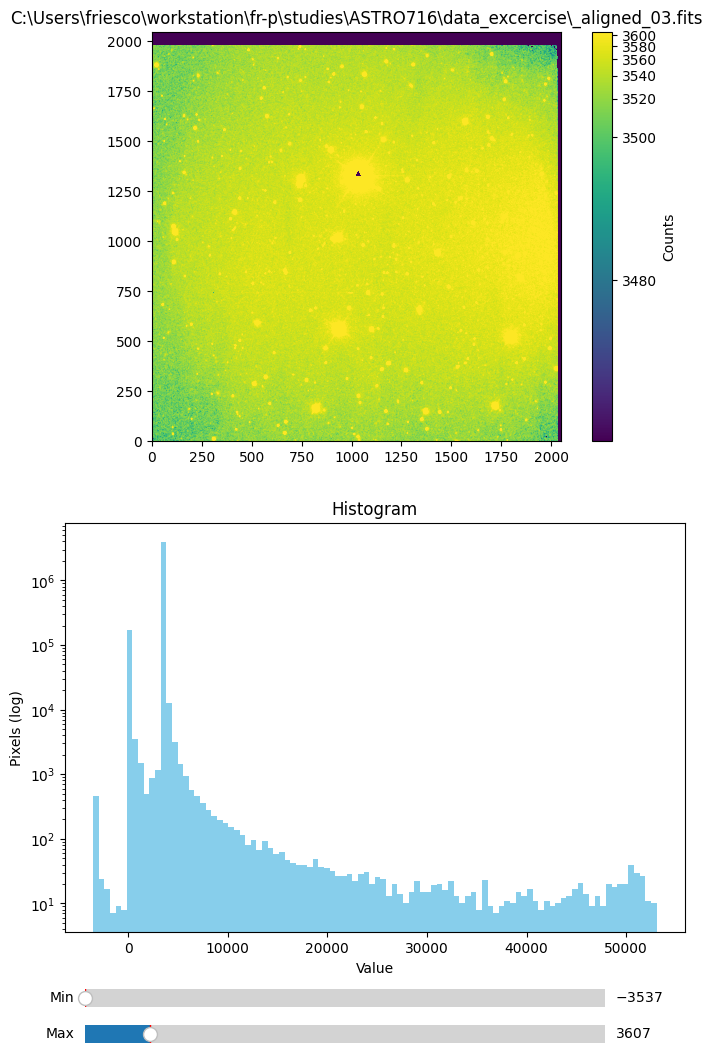

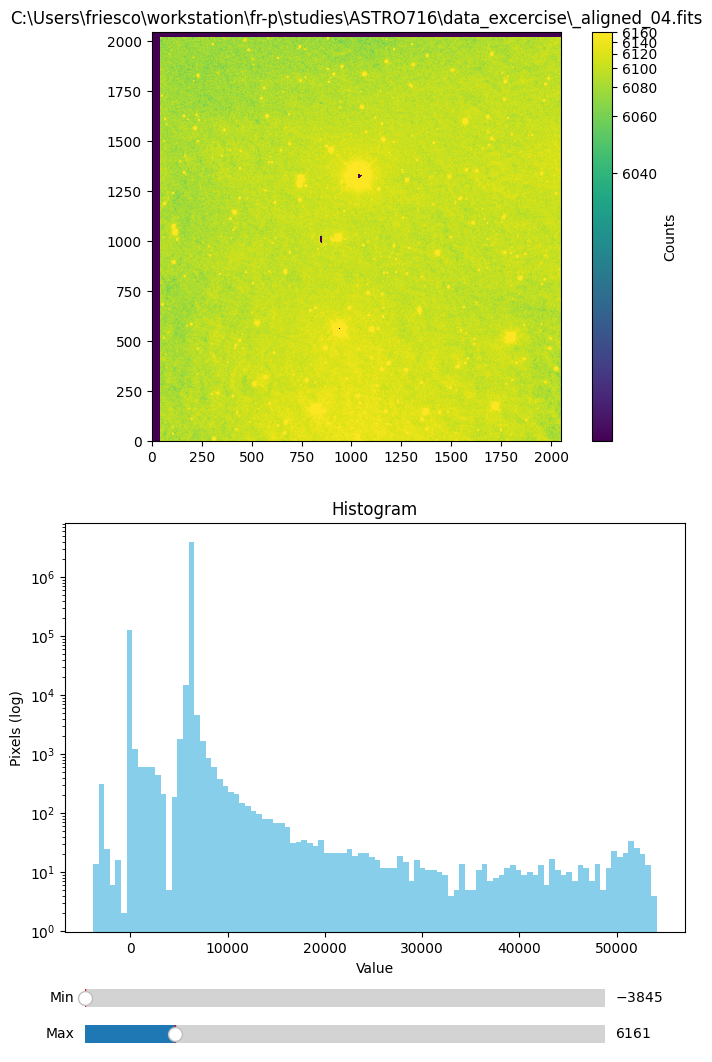

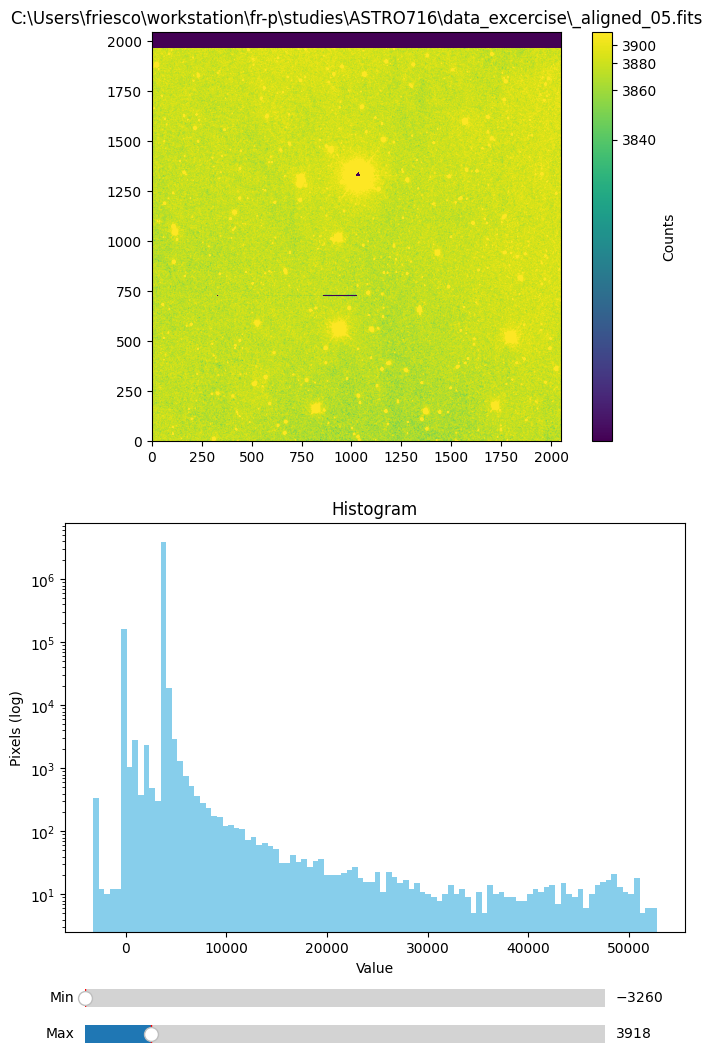

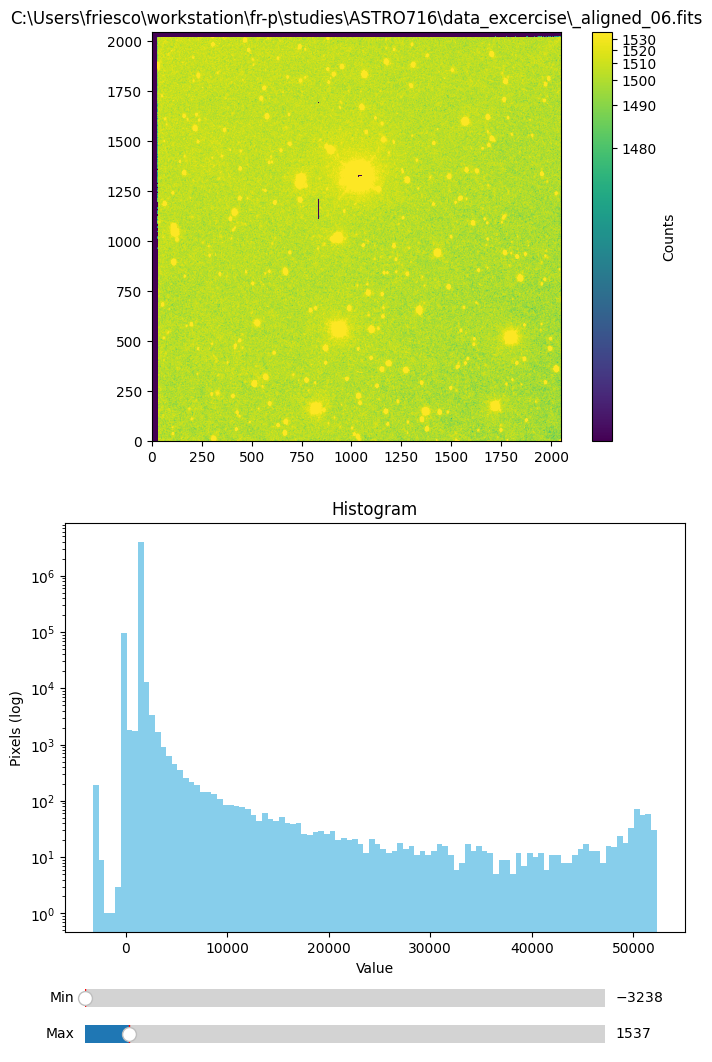

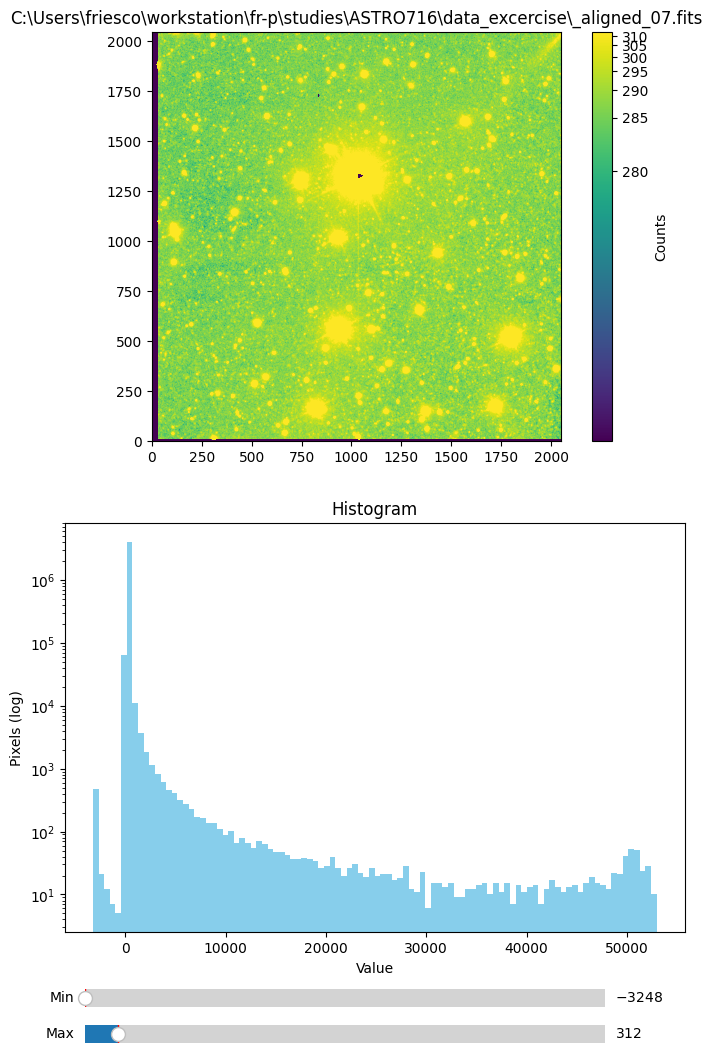

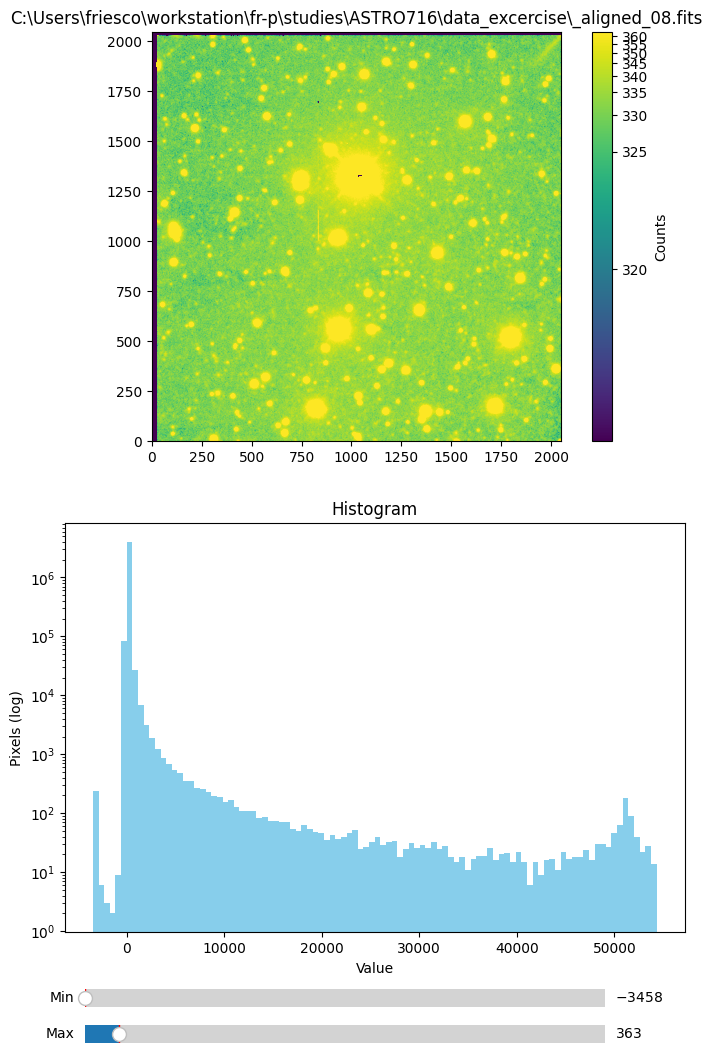

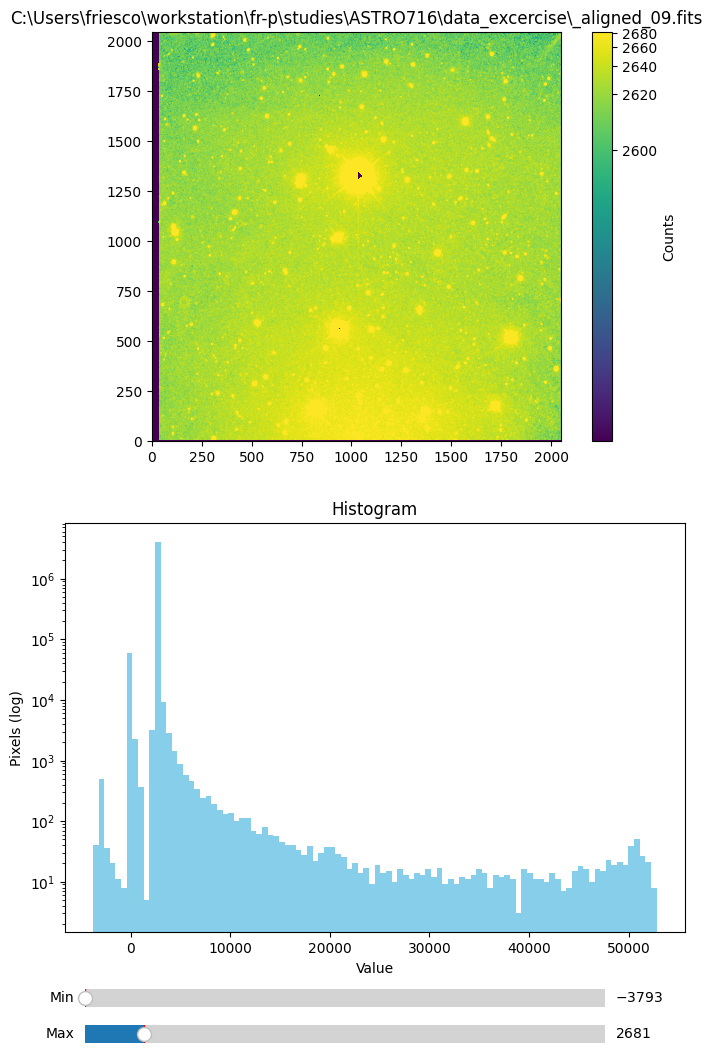

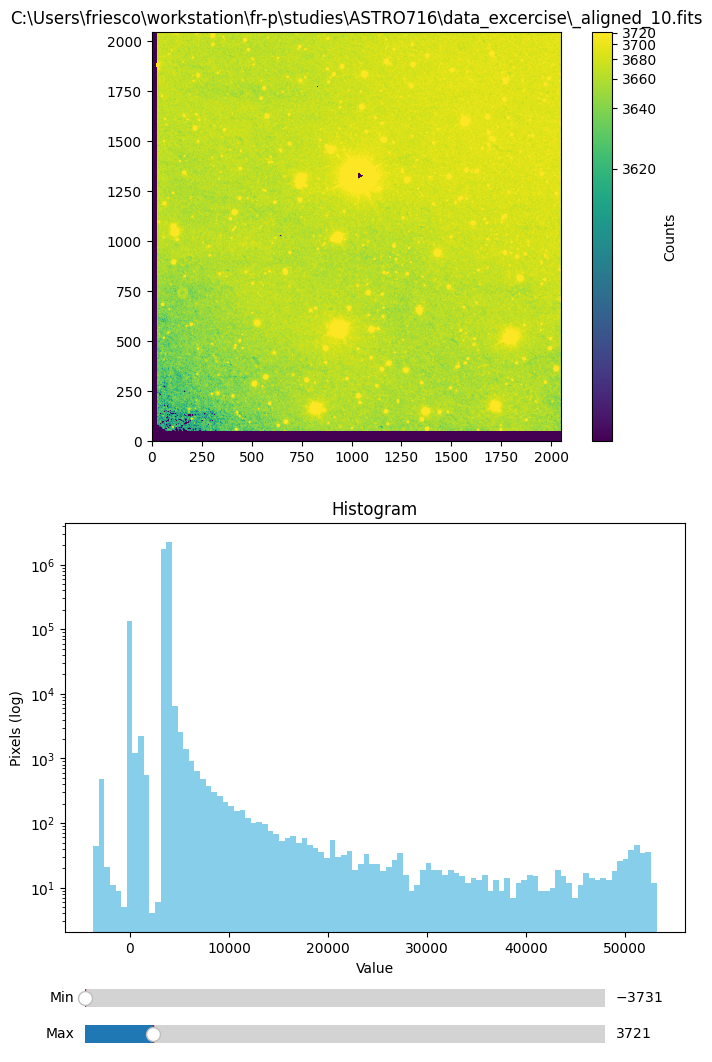

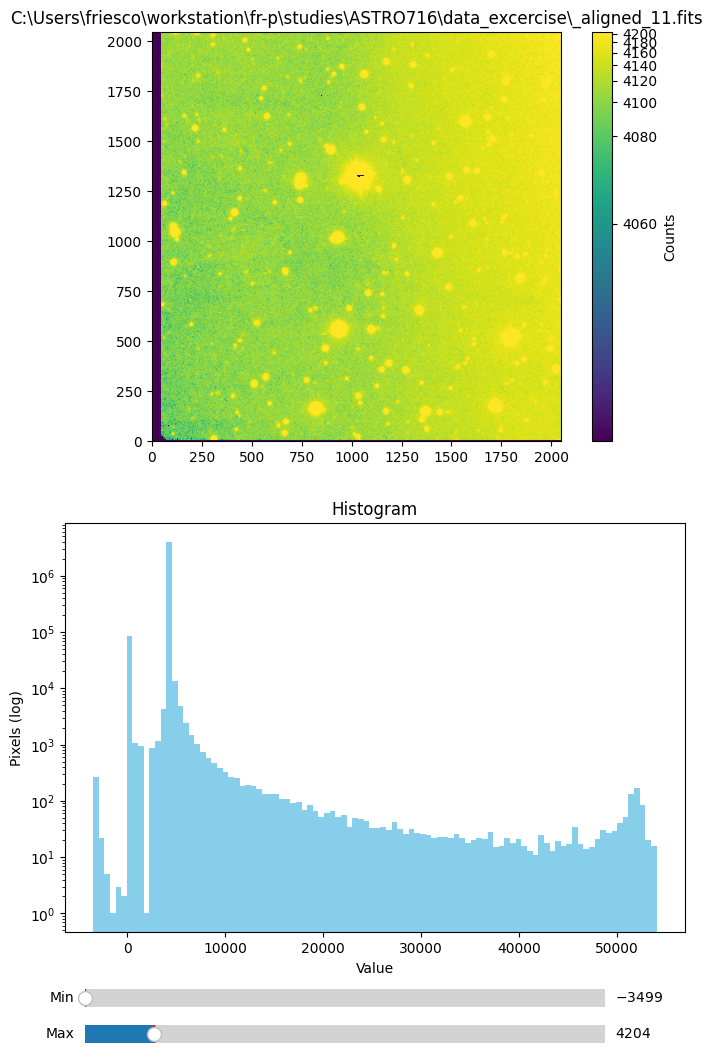

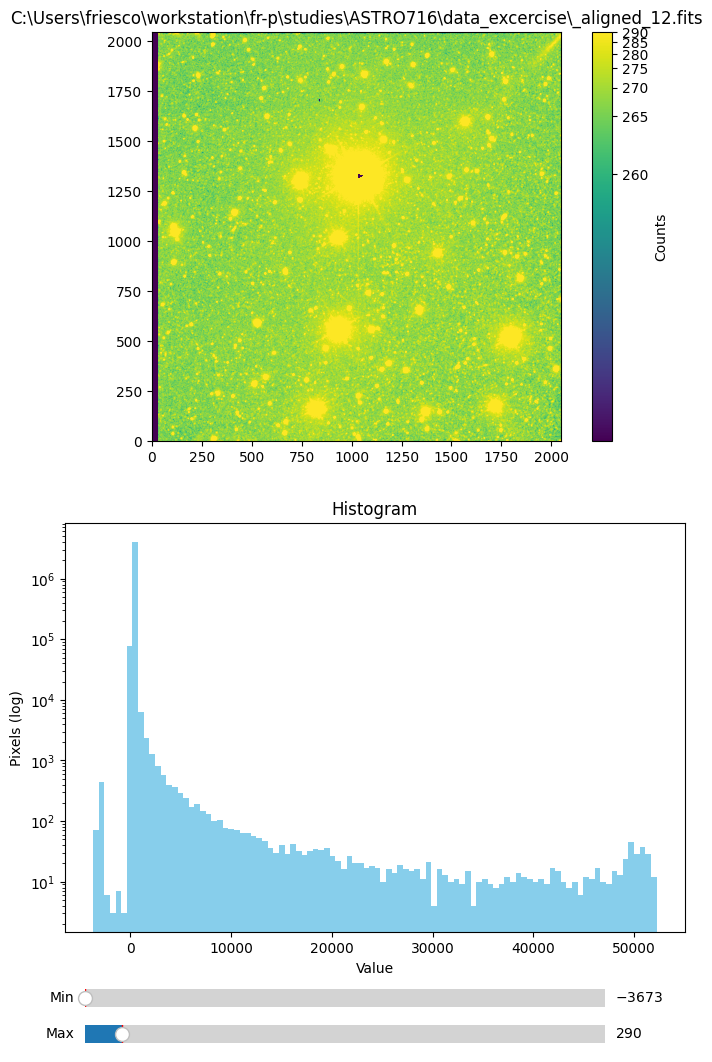

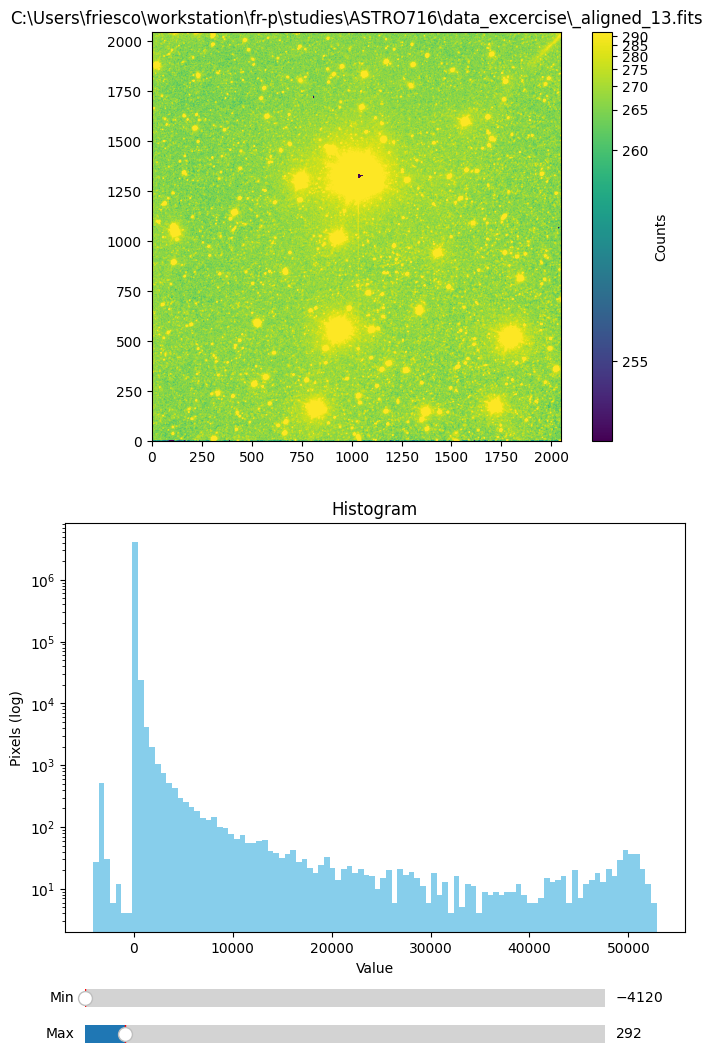

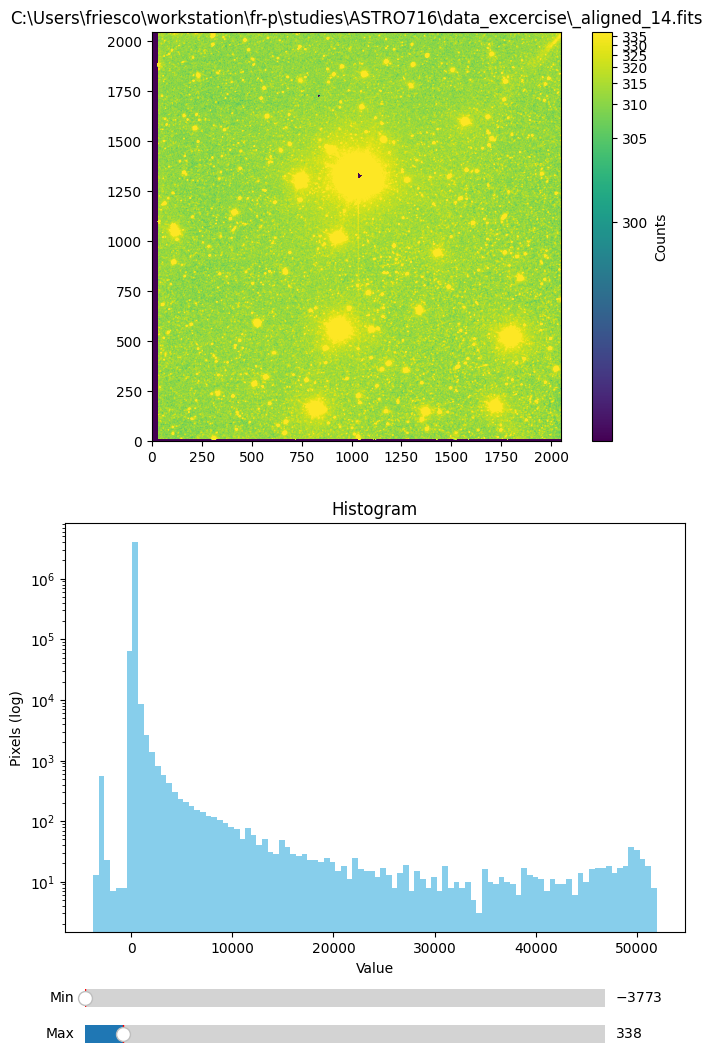

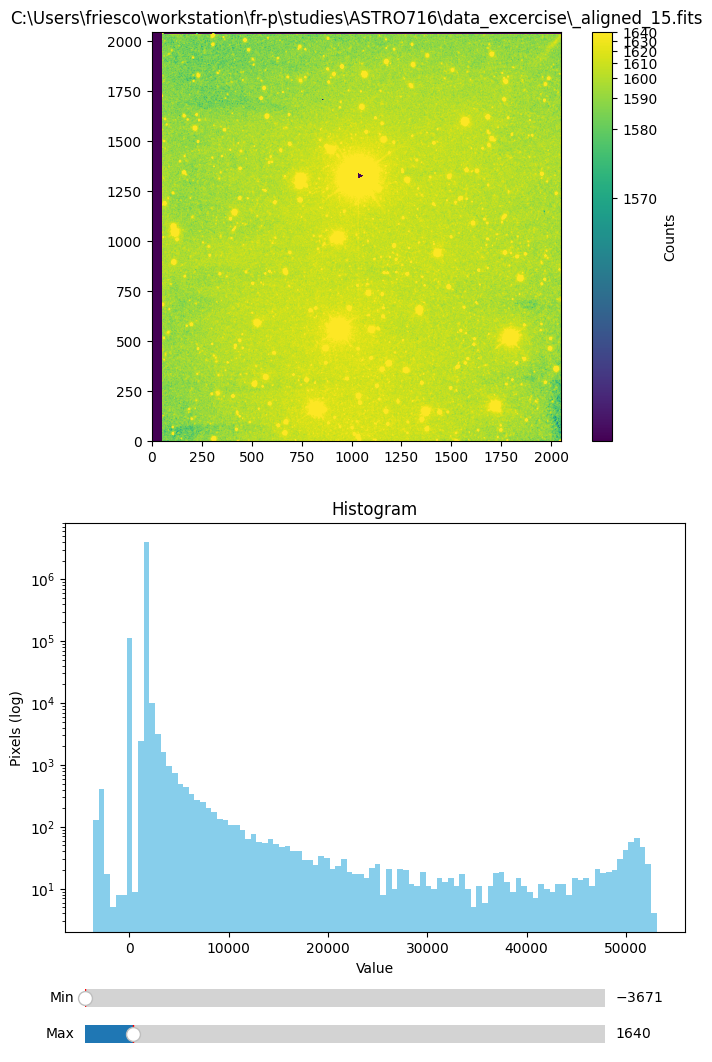

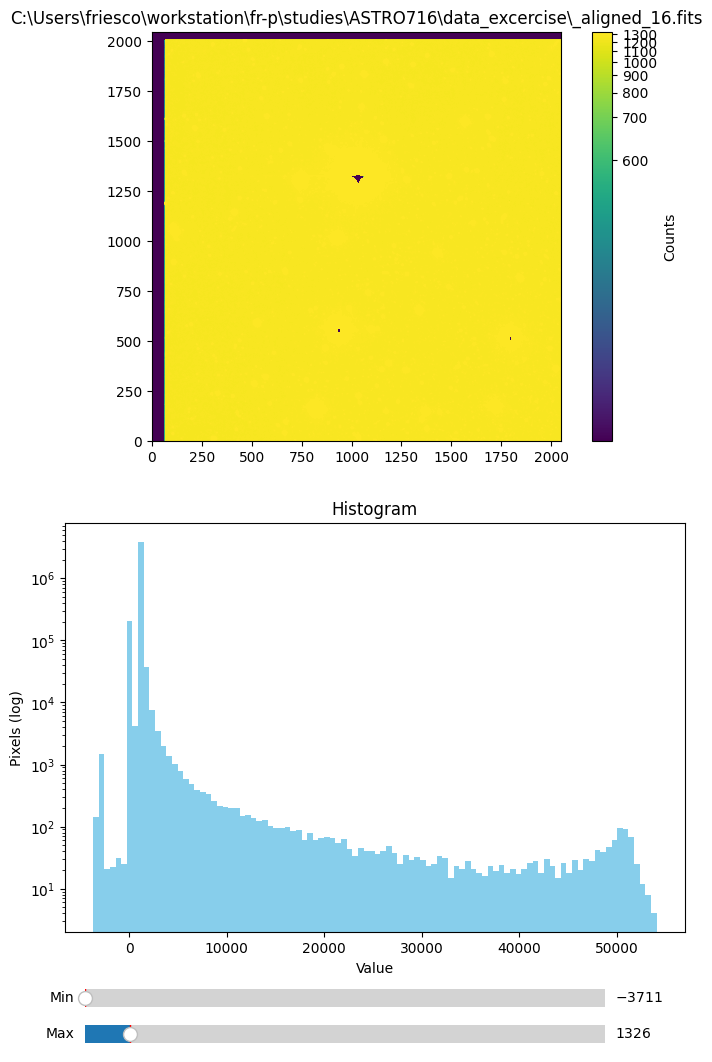

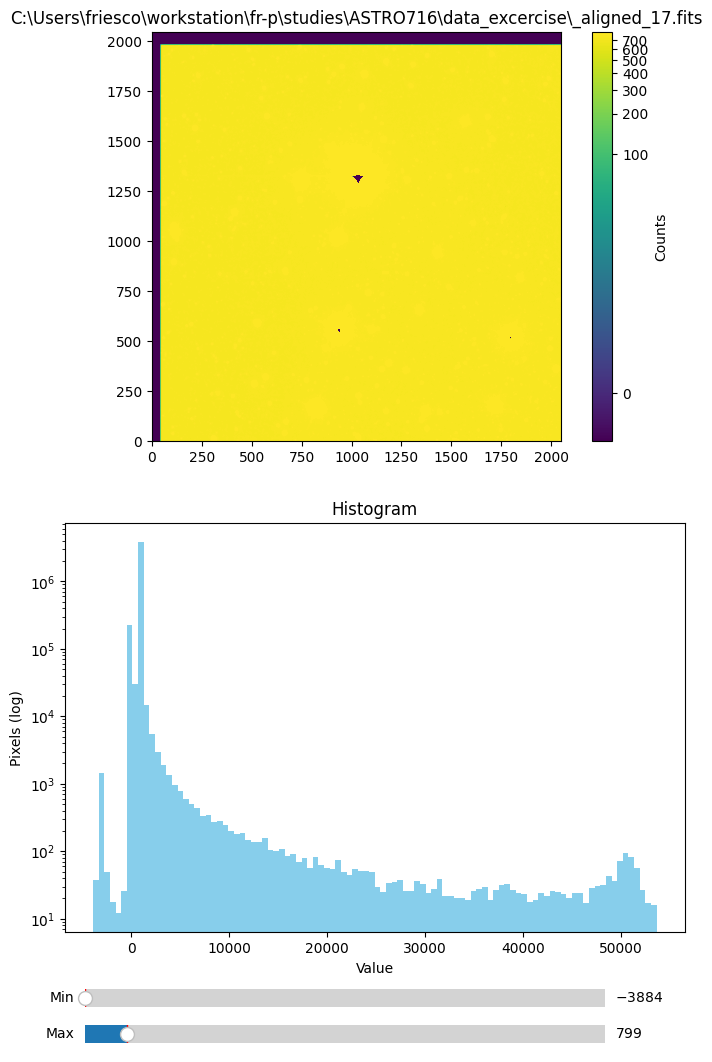

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from photutils.detection import DAOStarFinder
from photutils.background import Background2D, MedianBackground
import os
import pandas as pd
import shutil
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from matplotlib.widgets import Slider

wd = r"C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise"

def align_imgs(ref_img, imgs, tsv):
    aligned = []
    ref_hdu = fits.open(ref_img)
    ref_data = ref_hdu[0].data
    ref_wcs = WCS(ref_hdu[0].header)
    ref_hdu.close()

    data = []
    with open(tsv, 'r') as f:
        for ln in f:
            if ln.startswith('#') or len(ln.split('\t')) < 23:
                continue
            data.append(ln.strip().split('\t'))

    cols = ['ID', '_r', '_RAJ', '_DEJ', 'RAJ', 'DEJ', 'objID', 'f_objID', 'Qual', 'Ns', 'Nd', 'gmag', 'e_gmag', 'gFlags', 'rmag', 'e_rmag', 'rFlags', 'imag', 'e_imag', 'iFlags', 'zmag', 'e_zmag', 'zFlags']
    df = pd.DataFrame(data, columns=cols)

    df['RAJ'] = pd.to_numeric(df['RAJ'], errors='coerce')
    df['DEJ'] = pd.to_numeric(df['DEJ'], errors='coerce')
    df.dropna(subset=['RAJ', 'DEJ'], inplace=True)

    ref_stars = df.head(3)
    ref_coords = {f'star{i+1}': (r['RAJ'], r['DEJ']) for i, r in ref_stars.iterrows()}

    for img in imgs:
        hdu = fits.open(img)
        data = hdu[0].data
        wcs = WCS(hdu[0].header)
        ref_pix = {sn: wcs.world_to_pixel(SkyCoord(ra=ra, dec=dec, unit='deg')) for sn, (ra, dec) in ref_coords.items()}
        ref_pix = {k: v for k, v in ref_pix.items() if 0 <= v[0] < data.shape[1] and 0 <= v[1] < data.shape[0]}

        if not ref_pix:
            hdu.close()
            continue

        ref_pix = next(iter(ref_pix.values()))
        min_dist, close_star = float('inf'), None

        for _, row in df.iterrows():
            x, y = wcs.world_to_pixel(SkyCoord(ra=row['RAJ'], dec=row['DEJ'], unit='deg'))
            dist = np.hypot(ref_pix[0] - x, ref_pix[1] - y)
            if dist < min_dist:
                min_dist, close_star = dist, (x, y)

        dx, dy = ref_pix[0] - close_star[0], ref_pix[1] - close_star[1]
        wcs.wcs.crpix += [dx, dy]
        aligned.append(fits.PrimaryHDU(data, header=wcs.to_header()))
        hdu.close()

    return aligned

if __name__ == "__main__":
    ref_img = os.path.join(wd, "phot_00.fits")
    imgs = [os.path.join(wd, f"phot_{i:02d}.fits") for i in range(1, 18)]
    tsv = os.path.join(wd, "psdr1.tsv")
    aligned = align_imgs(ref_img, imgs, tsv)

    ref_out = os.path.join(wd, "_aligned_00.fits")
    shutil.copyfile(ref_img, ref_out)

    with fits.open(ref_out, mode='update') as hdu:
        hdu[0].header['ALIGNED'] = (True, 'Aligned image')
        hdu.flush()

    for i, hdu in enumerate(aligned):
        out = os.path.join(wd, f"_aligned_{i+1:02d}.fits")
        hdu.writeto(out, overwrite=True)
        print(f"Saved: {out}")

    aligned_files = [os.path.join(wd, f"_aligned_{i:02d}.fits") for i in range(18)]
    for file in aligned_files:
        try:
            hdu = fits.open(file)
            img_data = hdu[0].data
            hdu.close()
        except FileNotFoundError:
            print(f"Not found: {file}")
            continue

        fig, axs = plt.subplots(2, 1, figsize=(8, 12))
        norm = ImageNormalize(vmin=np.nanpercentile(img_data, 5), vmax=np.nanpercentile(img_data, 95), stretch=LogStretch())
        im = axs[0].imshow(img_data, origin='lower', cmap='viridis', norm=norm)
        fig.colorbar(im, ax=axs[0], label='Counts')
        axs[0].set_title(file)

        axs[1].hist(img_data.flatten(), bins=100, color='skyblue', log=True)
        axs[1].set_title('Histogram')
        axs[1].set_xlabel('Value')
        axs[1].set_ylabel('Pixels (log)')

        ax_min, ax_max = plt.axes([0.15, 0.08, 0.65, 0.03]), plt.axes([0.15, 0.05, 0.65, 0.03])
        s_min, s_max = Slider(ax_min, 'Min', np.nanmin(img_data), np.nanmax(img_data), valinit=np.nanmin(img_data)), Slider(ax_max, 'Max', np.nanmin(img_data), np.nanmax(img_data), valinit=np.nanpercentile(img_data, 95))

        def update(_):
            norm.vmin, norm.vmax = s_min.val, s_max.val
            im.set_norm(norm)
            fig.canvas.draw_idle()

        s_min.on_changed(update)
        s_max.on_changed(update)

        def on_move(event):
            if event.inaxes == axs[0]:
                x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
                try:
                    val = img_data[y, x]
                    fig.suptitle(f"Value at ({x}, {y}): {val:.2f}")
                    fig.canvas.draw_idle()
                except IndexError:
                    pass

        fig.canvas.mpl_connect('motion_notify_event', on_move)
        plt.subplots_adjust(bottom=0.15, top=0.9)
        plt.show()
